# CIFAR10 Classifier: PyTorch 

This notebook performs CIFAR10 classification on TPU 🏋🏽‍♀️ using:
- Resnet 50 as backbone
- Minimal augmentation

Most of the content is similar to the Pytorch GPU version of the notebook. 

---
@date: 19-Aug-2020 | @author: Katnoria

We begin by installing PyTorch XLA, which is needed to make use of TPU

In [6]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.2MB 65kB/s 
     |████████████████████████████████| 61kB 2.8MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [70]:
import os
import time
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import DataLoader, random_split

# XLA Specific
import torch_xla
import torch_xla.core.xla_model as xm


# If you wish to use tensorboard
# from tensorboardX import SummaryWriter

# For Confusion Matrix
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [11]:
torch.manual_seed(42)
np.random.seed(42)

In [12]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [16]:
print("Version Used in this Notebook:")
version_info(torch)
version_info(np)
import matplotlib as mpl
version_info(mpl)
import tqdm as tq
version_info(tq)
version_info(torch_xla)

Version Used in this Notebook:
torch: 1.6.0+cu101
numpy: 1.18.5
matplotlib: 3.2.2
tqdm: 4.41.1
torch_xla: 1.6


In [17]:
# Acquire the TPU
device = xm.xla_device()

# 1. Load Dataset

In [18]:
# Hyper params
BATCH_SIZE=128
NUM_WORKERS=8

In [19]:
# We are not using any augmentations here
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tuple([0.5]*3), tuple([0.5]*3))
])

In [20]:
ROOT_PATH = "/tmp/cifar10"
# Load the dataset
train_ds = datasets.CIFAR10(
    root=ROOT_PATH, train=True, 
    download=True, transform=transform
)
# Create train and validation splits
train, val = random_split(train_ds, [45000, 5000])
# Create data loaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Extracting /tmp/cifar10/cifar-10-python.tar.gz to /tmp/cifar10


In [21]:
# Load test dataset
test_ds = datasets.CIFAR10(
    root=ROOT_PATH, train=False, 
    download=True, transform=transform
)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified


## 1.1 Review Data

We plot some images from the training set.

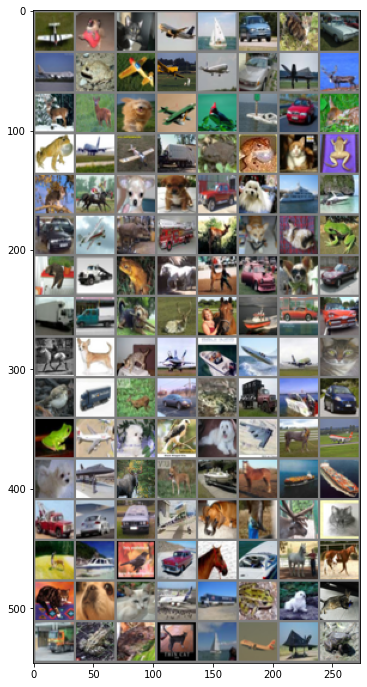

In [22]:
# Display images
images, labels = iter(train_loader).next()

# see: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(utils.make_grid(images))

# 2. Build Model

We will use imagenet pre-trained ResNet50 model. You can swap out the base model with others such as ResNet 18 or ResNet 110. Just make sure the input features of the final linear layer matches with the out features of your base model.

In [23]:
base_model = models.resnet50(pretrained=True)
# We do not want to
for param in base_model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [72]:
class SimpleNet(nn.Module):
    def __init__(self, base_model):
        super(SimpleNet, self).__init__()
        self.base_model = base_model
        # FC will be set as requires_grad=True by default
        self.base_model.fc = nn.Linear(2048, 10)
        
    def forward(self, x):
        x = self.base_model(x)
        return x
    
net = SimpleNet(base_model)
net.to(device)

SimpleNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [73]:
# Optimizer and loss function
# Hyperams are same as here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
LR=1e-3
MOMENTUM=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [74]:
# Define the training loop
def train(epochs, net):
    pbar = tqdm(range(epochs))
    best_loss = np.inf
    # track training time
    training_start = time.time()
    metrics = defaultdict(list)
    for idx, epoch in enumerate(pbar):
        # set the network into training mode
        net.train()
        epoch_loss = 0
        running_corrects = 0
        for idx, record in enumerate(train_loader):
            images, labels = record
            images = images.to(device)
            labels = labels.to(device)
            # zero grad the optimizer
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                preds = net(images)
                loss = criterion(preds, labels)                
                loss.backward()
                xm.optimizer_step(optimizer, barrier=True)
                # track losses
                epoch_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                running_corrects += torch.sum(predicted == labels).item()
                
        train_loss = epoch_loss / len(train_loader)
        train_acc = running_corrects / len(train_loader)
        # track
        metrics['train_acc'].append(train_acc)        

        pbar.set_description(f"Train Loss: {train_loss:4f} | Acc: {train_acc:.4f}")
        if epoch_loss < best_loss:
            print(f"Best loss changed from {best_loss:.4f} to {epoch_loss:.4f}")          
            best_loss = epoch_loss

            
        # Validation accuracy
        val_acc = test_model(net, val_loader)
        metrics['val_acc'].append(train_acc)        
        print(f"Epoch: {epoch}: train_loss={train_loss}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")            
    # print training time
    total_time = time.time() - training_start
    print(f"Total training time {total_time//60 :.0f}m {total_time%60:.0f}s")        
    return metrics

def predict(model, loader):
    """
    Predicts the images from the given loader    
    """
    model.eval()
    predictions = []
    true_labels = []
    for idx, record in enumerate(loader):
        images, labels = record
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        _, predicted = torch.max(preds.data, 1)        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

def test_model(model, loader):
    """
    Utility method to get the accuracy of the model
    """    
    corrects = 0
    predicted, labels = predict(model, loader)
    corrects += np.sum(np.array(predicted) == np.array(labels))
    return corrects/len(loader)

In [75]:
def get_confusion_matrix(model, loader):
    """Returns the confusion matrix"""
    predicted, true_labels = predict(model, loader)    
    cm = confusion_matrix(true_labels, predicted)
    return {
        "predicted": predicted,
        "true_labels": true_labels,
        "matrix": cm
    }

# 3. Train

We are now ready to train our model.

In [76]:
EPOCHS=50
history = train(EPOCHS, net)

Best loss changed from inf to 640.7364
Epoch: 0: train_loss=1.8202737481756643, train_acc=48.6278, val_acc=56.8750
Best loss changed from 640.7364 to 553.6472
Epoch: 1: train_loss=1.572861329398372, train_acc=60.2045, val_acc=60.1750
Best loss changed from 553.6472 to 529.6344
Epoch: 2: train_loss=1.5046433213759551, train_acc=62.7358, val_acc=62.2750
Best loss changed from 529.6344 to 515.7778
Epoch: 3: train_loss=1.465277823534879, train_acc=64.2670, val_acc=63.3000
Best loss changed from 515.7778 to 506.4376
Epoch: 4: train_loss=1.438743151047013, train_acc=65.4034, val_acc=63.2250
Best loss changed from 506.4376 to 498.5874
Epoch: 5: train_loss=1.4164414151825688, train_acc=66.1420, val_acc=64.5250
Best loss changed from 498.5874 to 492.4250
Epoch: 6: train_loss=1.3989345627752217, train_acc=67.0085, val_acc=65.0750
Best loss changed from 492.4250 to 485.1338
Epoch: 7: train_loss=1.3782209604978561, train_acc=68.2102, val_acc=65.0000
Best loss changed from 485.1338 to 482.6273
Epoc

In [77]:
test_accuracy = test_model(net, test_loader)
print(f"Test Accuracy {test_accuracy:4f}")

Test Accuracy 69.215190


## 4.2: Confusion Matrix

Let's plot to confusion matrix to find out more how much of predictions does our model get right.

In [78]:
cm = get_confusion_matrix(net, val_loader)

In [79]:
cm["matrix"]

array([[250,  21,  53,   8,  12,  10,   6,   9,  94,  25],
       [  7, 327,  15,  20,   8,  13,  11,   8,  34,  69],
       [ 41,   5, 245,  28,  68,  42,  51,  19,  25,   8],
       [ 15,  19,  33, 184,  37, 100,  33,  23,  18,   9],
       [ 15,   8,  33,  30, 253,  34,  41,  36,  13,   8],
       [ 10,  15,  33,  65,  38, 280,  30,  24,   5,  14],
       [  6,   7,  42,  41,  57,  27, 308,   7,   4,   8],
       [ 15,  19,  26,  24,  65,  51,  16, 246,  13,  25],
       [ 65,  23,  12,  12,  13,   5,   6,   8, 339,  21],
       [ 16,  63,   5,  18,  11,  22,   6,  17,  40, 303]])

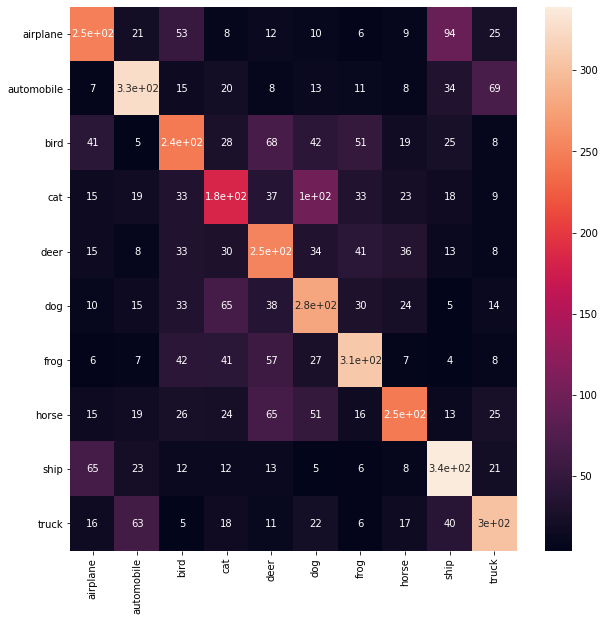

In [80]:
labels = [label for label in train_ds.classes]
df = pd.DataFrame(cm["matrix"], index=labels, columns=labels)
plt.figure(figsize=(10,10))
sns.heatmap(df, annot=True)
plt.show()

# 4. Next Steps

This is a very simple example of training CIFAR10 classifier using a pre-trained network. Its your turn to tune the knob and see if you can get model to generalise better. Some ideas:

- make the model overfit your training data
- regularize the model to generalize better
- increase/decrease model capacity based on what you find in above steps
- add image augmentation
- use hyperparameter tuning library to find the best set of combination
- rollout your own model from scratch, you can use the tuning library to help design the network too
